<a href="https://colab.research.google.com/github/oscarserc/TESIS/blob/main/PASO_1____Simulacion_de_una_Red_Social_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SIMULACIÓN de una Red Social**

OBJETIVO:

1) Construir un modelo con la dinámica emocional de una Red Social.


**PROCEDIMIENTO**:

· Simularemos el comportamiento en una Red Social regular (en forma de cuadrícula)

· Emplearemos agentes diseñados para comportarse guiados por sus emociones. Se utilizan técnicas de Aprendizaje por Refuerdo (*Reinforcement* *Learning*)

· Los agentes toman decisiones basándose en su estado emocional.

· Los agentes interaccionan entre sí empleando el conocido como el Dilema del prisionero. Es un modelo básico de interacción , y se programará estudiando las reacciones emocionales de los agentes ante cada lance particular del juego del Prisionero.

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/Dilema_Prisionero.png?raw=true' width="250"/>
<figcaption>fig. 3: Matriz de pagos del Dilema del Prisionero</figcaption></center>
</figure>


#**1). Cargamos algunas librerías empleadas en la creación de agentes y fijamos los valores de los parámetros.**

In [ ]:

# Importamos las LIBRERÍAS
import numpy as np
import pandas as pd
import random

# En primer lugar procedemos a especificar los parámetros que se emplearán a lo largo del
# PROGRAMA
# =======================================================================================
# PARÁMETROS
# ----------
alfa    = 0.1     # TASA DE APRENDIZAJE
gamma   = 0.1     # TASA DE DESCUENTO
epsilon = 0.01    # probabilidad de EXPLORACIÓN    #----> PRIMERO PUSE 0.2
num_estados  = 4  # EMOCIONES - Pongo 4: Alegría, Tristeza, Ira, Miedo 
num_acciones = 2  # Cooperar o NoCooperar

# Recompensas intrínsecas
r_alegria      = 1       # Quizás poner 1, (2 parece un poco arbitrario)
r_ira          = 1
r_tristeza     = 1
r_miedo        = 1
beta           = 0.5

# TAMAÑOS POBLACIONALES (Inicialmente ponemos todos AGENTES EMOCIONALES)
probabilidad_clases = np.zeros(3)
# Para la experimentación con TRAIDORES poner un parámetro 'p' por ejemplo, y hacerlo recorrer el intervalo
#     p in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1)
#            probabilidad_clases[0] = 1 - p
#            probabilidad_clases[1] = p
probabilidad_clases[0] = 1.0    # Primer punto de corte > Si es menor que: 100 deja hueco por encima a  TRAIDOR  INGENUO  Tit-for-Tat
probabilidad_clases[1] = 0.0    #                         Por encima:                                      -     INGENUO  Tit-for-Tat
probabilidad_clases[2] = 0.0    #                         Por encima:                                      -        -     Tit-for-Tat

# TAMAÑO DE LA CUADRICULA (Grid) - Por ejemplo: (size=10)  =>  (10 filas x 10 columnas)
size = 10 # 20

# COMPROBACIÓN DE SEGURIDAD: Voy a ver si los objetos son alterados 
LISTA_IDs      = []
# -----------------------------------------------------------------

LISTA_MUTANTES = []
LISTA_NODOS_VECINOS = []
MATRIZ_ADYACENCIA_Red_Social = np.zeros((size*size + 1, size*size + 1))


#**2). Definimos las clases de los AGENTES que intervienen en el programa**

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/Jerarquia_Objetos_Agente_1a.png?raw=true' width="600"/>
<figcaption></figcaption></center>
</figure>

Partimos de un AGENTE EMOCIONAL. Es el objeto principal, y a partir de él creamos otros 3 tipos de Agentes MUTANTES, que toman decisiones como un Autómata Celular.

#A) CLASE AGENTE EMOCIONAL

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/grafo_4B_GLOBAL_A%C3%B1ado_Miedo_2.png?raw=true' width="700"/>
<figcaption></figcaption></center>
</figure>

Las EMOCIONES que gobiernan la toma de decisiones del agentes podemos analizarlas separadamente. En color amarillo vemos el tipo de transiciones emocionales a las que se enfrenta el AGENTE, según la decisión de su oponente (*en linea discontinua*) partiendo de su propia decisión (*en linea continua*). A continuación aparece el gráfico asociado a las emociones MIEDO e IRA.

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/grafo_4B_IRA_Marco.png?raw=true' width="430"/>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/grafo_4B_MIEDO_Marco_2.png?raw=true' width="470"/>
<figcaption></figcaption></center>
</figure>

Las transiciones asociadas a las emociones TRISTEZA y ALEGRÍA aparecen a continuación.

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/grafo_4_TRISTEZA_Marco.png?raw=true' width="430"/>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/grafo_4_ALEGRIA_Marco.png?raw=true' width="470"/>
<figcaption></figcaption></center>
</figure>



In [ ]:

# CLASE PRINCIPAL
# ===============

# 1) Clase AGENTE EMOCIONAL >>> Primera prueba: (Agente con exploración epsilon-greedy)
# -------------------------

class AgenteEmocional(object):
  def __init__(self, alfa=0.1, gamma=0.1):
     self.alfa     = alfa
     self.gamma    = gamma
     self.estados  = num_estados
     self.acciones = num_acciones
     self.MUTANTE               = 0  
     self.TRAICIONADO           = 0  # A cero mientras no sea traicionado
     self.num_vecinos           = 0
     self.Numero_nodo           = 0
     self.lista_nodos_vecinos   = [] # Preparo para distribuir pagos a todos los jugadores que intervienen en la jugada
     self.lista_vecinos_grid    = [] # y para crear una MATRIZ de ADYACENCIA y dibujar un grafo de la Red-Grid
     
     # RECOMPENSAS y GANANCIAS
     # -----------------------
     self.recompensa            = 0
     self.recompensa_intrinseca = 0
     self.ganancias             = []
     self.ganancias_acumuladas  = []
     
     # ESTADOS EMOCIONALES (S y S')                 # AQUÍ ALEATORIZAMOS LA EMOCIÓN INICIAL  <-------- Octubre 2022 (Probar INICIO FORZADO)
     # ----------------------------
     #                                              # 3 Octubre de 2022
     # self.emocion = 1
     self.emocion               = np.random.randint(num_estados) # Emocion inicial
     self.emocion_tras_jugada   = 0                              # Un valor cualquiera, se modificará de inmediato
     self.MATRIZ_ADYACENCIA_EMOCIONES = np.zeros((4,4))          # GUARDAMOS LAS TRANSICIONES
     self.SERIE_ALEGRIA         = []
     self.SERIE_ALEGRIA.append(0)
     self.SERIE_IRA             = []
     self.SERIE_IRA.append(0)
     self.SERIE_TRISTEZA        = []
     self.SERIE_TRISTEZA.append(0)
     self.SERIE_MIEDO           = []
     self.SERIE_MIEDO.append(0)
     if (self.emocion == 0):
       self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
     elif (self.emocion == 1):
       self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1
     elif (self.emocion == 2):
       self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1
     elif (self.emocion == 3):
       self.SERIE_MIEDO[-1] = self.SERIE_MIEDO[-1]+1
     # Usaremos CODIFICACIÓN:    ALEGRIA = 0  /  IRA = 1  /  TRISTEZA = 2  /  MIEDO = 3
    
     # DECISIONES
     # ----------
     self.accion_propia         = 0  # Un valor cualquiera, se modificará de inmediato
     self.accion_vecindario     = 0  # Un valor cualquiera, se modificará de inmediato
     self.numero_cooperadores   = 0 
     self.DECISIONES            = []
     self.contador_inicio       = 0  # USO UN CONTADOR PARA TitForTat  # <--------------------------------------------- Para generar estrategia TIT for TAT
     self.SERIE_COOPERACIONES   = []
     self.SERIE_COOPERACIONES.append(0)

     # PROCESO DE APRENDIZAJE
     # ----------------------
     self.matriz_Q = np.zeros((num_estados, num_acciones))
     self.ERRORES               = []

  def Fijar_vecinos(self,vecinos):
    self.num_vecinos = vecinos

  def Vecinos(self):
    return self.num_vecinos  

  def Fijar_num_cooperadores(self, numero):
    self.numero_cooperadores = numero

  def Fijar_intensidad_emocional(self, intensidad):
    self.intensidad_emocional = intensidad

  def Q(self):
    return self.matriz_Q

  def Mutar(self, identidad):
    self.MUTANTE = identidad

  def Mutante(self):
    return self.MUTANTE  

  # DECISIONES: epsilon-greedy
  def Tomar_decision(self, estado):
    # ---------------------------------
    # LA LLAMADA PARA LA TOMA DE DECISIONES SE REALIZA EN EL PROCEDIMIENTO
    # step()
    # -------------------------------------------------------------------------------
    TRAIDOR   = 1 # No coopera nunca
    INGENUO   = 2 # Coopera siempre a ciegas
    TitForTat = 3 # Coopera hasta que le traicionan y DEJA DE COOPERAR PARA SIEMPRE
    
    valor_aleatorio = np.random.uniform(0,1)

    # DECISIÓN e-greedy
    # -----------------
    if valor_aleatorio < epsilon:
        accion = np.random.randint(num_acciones)          # epsilon-probabilidad
        self.accion_propia = accion   # <---------------- Aquí surge la ACCIÓN inicio
    else:
        Qs = self.matriz_Q[estado]  
        accion = np.argmax(Qs)                            # max Q(s,a)
        self.accion_propia = accion   # <---------------- Aquí surte la ACCIÓN inicio
    # -------------------------------------------------------------------------------    
        


    # ==============================
    #  PODAR ESTA SECCIÓN DE CÓDIGO  : Para que no contamine al AGENTE EMOCIONAL, que ya nada tiene que ver con los otros AGENTES MUTANTES
    # ==============================
    # Si es MUTANTE toma decisiones de la siguiente manera:    
    if (self.MUTANTE == TRAIDOR):           # AGENTE TRAIDOR
        accion = 0   
        self.accion_propia = 0 
    elif (self.MUTANTE == INGENUO):         # AGENTE INGENUO
        accion = 1
        self.accion_propia = 1
    elif (self.MUTANTE == TitForTat):       # AGENTE TitForTat
        if (self.contador_inicio == 0):     # ACTUALIZAR EL CONTADOR
            accion = 1
            self.accion_propia = 1
        else:
            accion = self.accion_vecindario
            self.accion_propia = self.accion_vecindario
    # ----------------------------------------------------- 
    self.contador_inicio = self.contador_inicio + 1
    self.accion_propia = accion  # <------------------------------------------------------- O CENTRALIZADO AQUÍ
    # ==============================
    #  PODAR ESTA SECCIÓN DE CÓDIGO  
    # ============================== 


    return accion



  def Accion(self):
    return self.accion_propia

  def Accion_vecindario(self, accion_vecinos):
    self.accion_vecindario = accion_vecinos

  def Recompensa(self, recompensa):
    self.recompensa = recompensa


  def nuevo_estado(self, accion_vecindario):
    ALEGRIA      = 0
    IRA          = 1
    TRISTEZA     = 2  
    MIEDO        = 3

    No_COOPERAR  = 0
    COOPERAR     = 1
    
    # Series temporales de estados emocionales
    # ----------------------------------------
    self.SERIE_ALEGRIA.append(self.SERIE_ALEGRIA[-1])
    self.SERIE_IRA.append(self.SERIE_IRA[-1])
    self.SERIE_TRISTEZA.append(self.SERIE_TRISTEZA[-1])
    self.SERIE_MIEDO.append(self.SERIE_MIEDO[-1])
    # ------------------------------------------------------------------

    # Parámetro de DESESCALADA
    # -------------------------
    Beta                 = 0.5
    evaluacion_situacion = np.random.uniform(0,1)
    # ----------------------------------------

    #
    # Partimos de Estado inicial: ALEGRÍA  ('0')
    # ---------------------------
    if ((self.emocion == ALEGRIA) and (self.accion_propia == COOPERAR)):              # Está ALEGRE y COOPERA
        if (self.accion_vecindario == COOPERAR):           #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = ALEGRIA
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
            self.recompensa_intrinseca = r_alegria
            self.MATRIZ_ADYACENCIA_EMOCIONES[ALEGRIA][ALEGRIA] += 1
        else:                                       #  <---------  Vecinos No COOPERAN
            self.emocion_tras_jugada   = IRA  
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1    
            self.recompensa_intrinseca = 0  
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[ALEGRIA][IRA] += 1
    elif ((self.emocion == ALEGRIA) and (self.accion_propia == No_COOPERAR)):      # Está ALEGRE y NoCOOPERA
        if (self.accion_vecindario == COOPERAR):
            self.emocion_tras_jugada   = TRISTEZA
            self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1
            self.recompensa_intrinseca = 0
            self.MATRIZ_ADYACENCIA_EMOCIONES[ALEGRIA][TRISTEZA] += 1
        else:
            self.emocion_tras_jugada   = ALEGRIA  
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1    
            self.recompensa_intrinseca = 0  
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[ALEGRIA][ALEGRIA] += 1

    # Partimos de Estado inicial: IRA  ('1')
    # ---------------------------
    if (self.emocion == IRA) and (self.accion_propia == COOPERAR):                 # Está IRACUNDO y COOPERA              
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN                                      
            self.emocion_tras_jugada   = ALEGRIA                                                                          
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1                                                             
            self.recompensa_intrinseca = 0                                                                                
            self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][ALEGRIA] += 1   # parece error IRA y VECINOS COOPERAN => TRISTEZA   
        else:                                        #  <---------  Vecinos No COOPERAN
            self.emocion_tras_jugada   = IRA   
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1   
            self.recompensa_intrinseca = 0  
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][IRA] += 1

    elif (self.emocion == IRA) and (self.accion_propia == No_COOPERAR):          # Está IRACUNDO y NoCOOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = TRISTEZA
            self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1
            self.recompensa_intrinseca = 0
            self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][TRISTEZA] += 1
        else:                                        #  <---------  Vecinos No COOPERAN
            # TIENE SUFICIENTE GRAVEDAD COMO PARA NO CONSIDERAR
            # NINGÚN FACTOR PARA DESESCALAR
            if   (evaluacion_situacion >= Beta):
                self.emocion_tras_jugada   = IRA   
                self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1   
                self.recompensa_intrinseca = r_ira  
                self.TRAICIONADO = 0    # Antes a 1, pongo a 0
                self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][IRA] += 1
            # AHORA SI SE SIENTE SOBREPASADO POR LA SITUACIÓN
            # Y ES MEJOR DESESCALAR
            # Beta ----> Tendencia a eludir la confrontación
            #            No es para tanto, y merece la pena frenar
            elif (evaluacion_situacion < Beta):      
                self.emocion_tras_jugada   = MIEDO   
                self.SERIE_MIEDO[-1] = self.SERIE_MIEDO[-1]+1  
                self.recompensa_intrinseca = 0  
                self.TRAICIONADO = 0     # CREO QUE ASÍ
                self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][MIEDO] += 1
            

    # Partimos de Estado inicial: TRISTEZA  ('2')
    # ---------------------------
    if (self.emocion == TRISTEZA) and (self.accion_propia == COOPERAR):        # Siente CULPABILIDAD y COOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = ALEGRIA
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
            self.recompensa_intrinseca = r_tristeza
            self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][ALEGRIA] += 1
        else:                                        #  <---------  Vecinos No COOPERAN
            self.emocion_tras_jugada   = IRA     
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1 
            self.recompensa_intrinseca = 0 
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][IRA] += 1
    elif (self.emocion == TRISTEZA) and (self.accion_propia == No_COOPERAR): # Siente CULPABILIDAD y NoCOOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = TRISTEZA
            self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1
            self.recompensa_intrinseca = 0
            self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][TRISTEZA] += 1                                                         
        else:                                        #  <---------  Vecinos COOPERAN                                          
            #self.emocion_tras_jugada   = IRA                                                                                 
            #self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1                                                                        
            self.recompensa_intrinseca = 0                                                                                    
            self.TRAICIONADO = 1
            #self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][IRA] += 1
            self.emocion_tras_jugada   = ALEGRIA
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
            self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][ALEGRIA] += 1

    # Partimos de Estado inicial: MIEDO  ('3')
    # ---------------------------
    if (self.emocion == MIEDO) and (self.accion_propia == COOPERAR):        # Siente CULPABILIDAD y COOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = ALEGRIA
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
            self.recompensa_intrinseca = r_miedo
            self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][ALEGRIA] += 1
        else:                                        #  <---------  Vecinos No COOPERAN
            self.emocion_tras_jugada   = IRA     
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1 
            self.recompensa_intrinseca = 0 
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][IRA] += 1
    elif (self.emocion == MIEDO) and (self.accion_propia == No_COOPERAR): # Siente CULPABILIDAD y NoCOOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN                                           
            self.emocion_tras_jugada   = TRISTEZA                        
            self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1          
            self.recompensa_intrinseca = 0
            self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][TRISTEZA] += 1
        else:                                        #  <---------  Vecinos COOPERAN
            if   (evaluacion_situacion >= Beta):
                self.emocion_tras_jugada   = IRA  
                self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1   
                self.recompensa_intrinseca = 0  
                self.TRAICIONADO = 0     # CREO QUE ASÍ 
                self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][IRA] += 1
            elif (evaluacion_situacion < Beta):      
                self.emocion_tras_jugada   = MIEDO   
                self.SERIE_MIEDO[-1] = self.SERIE_MIEDO[-1]+1  
                self.recompensa_intrinseca = 0  
                self.TRAICIONADO = 0     # CREO QUE ASÍ
                self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][MIEDO] += 1
    
    return self.emocion_tras_jugada

   
  def paso_aprendizaje(self):
    # ESTADOS:    s (estado) y s' (estado_nuevo)
    # --------
    estado = self.emocion         # ESTADO INICIO: Se asgna aleatoriamente en el INIT
    estado_nuevo = self.nuevo_estado(self.accion_vecindario)

    # RECOMPENSA: r
    # -----------
    # r = self.recompensa + self.recompensa_intrinseca
    r = self.recompensa_intrinseca    

    # ACCIÓN:     a (accion) y a' (accion_nueva)
    # -------
    accion = self.accion_propia
    accion_nueva = self.Tomar_decision(estado_nuevo)
    self.DECISIONES.append(accion_nueva)

    # Ahora incrementamos la última si COOPERA (En el init se hizo un append '0')
    if (accion):
        self.SERIE_COOPERACIONES[-1] = self.SERIE_COOPERACIONES[-1]+1
    self.SERIE_COOPERACIONES.append(self.SERIE_COOPERACIONES[-1])
    # Seguimos el rastro de las recompensas que recibe
    self.ganancias.append(r)
    if len(self.ganancias) > 1:
        self.ganancias_acumuladas.append(self.ganancias_acumuladas[-1] + self.ganancias[-1])
    else:
        self.ganancias_acumuladas.append(self.ganancias[-1])

    # --------------------
    # Algoritmo Q-Learning
    # --------------------
    # APRENDIZAJE:
    target = float(r) + gamma * self.matriz_Q[estado_nuevo].max()  
    error  = target - self.matriz_Q[estado][accion]
    self.ERRORES.append(error)
    self.matriz_Q[estado][accion] = self.matriz_Q[estado][accion] + (alfa*error)

    self.emocion = estado_nuevo
    self.accion_propia = accion_nueva



A continuación las CLASES DE AGENTES MUTANTES. En la medida en que todos introducen en PASO_APRENDIZAJE un mismo cambio, podría convenir definir una clase AGENTE_MUTANTE de la que heredan todos.

#B) CLASE AGENTE MUTANTE: Traidor

In [ ]:

class Agente_MUTANTE_Traidor(AgenteEmocional):
  def Tomar_decision(self, estado):
    return 0

  def paso_aprendizaje(self):
    # ESTADOS:    s (estado) y s' (estado_nuevo)
    # --------
    estado = self.emocion         # ESTADO INICIO: Se asgna aleatoriamente en el INIT
    estado_nuevo = self.nuevo_estado(self.accion_vecindario)

    # ACCIÓN:     a (accion) y a' (accion_nueva)
    # -------
    accion = self.accion_propia
    accion_nueva = self.Tomar_decision(estado_nuevo)                               # -------------------- 
    self.DECISIONES.append(accion_nueva)                                           # 3 de Octubre de 2022  -  MODIFICACIÓN: incluyo 'r' también
                                                                                   # --------------------
    # RECOMPENSA: r                                                                # LO PONGO PARA QUE NO DÉ ERROR. Ver si es necesario. Lo utilizo
    # -----------                                                                  # Para hacer seguimiento de las ganancias
    # r = self.recompensa + self.recompensa_intrinseca                             # ---------------------------------------------------------------
    r = self.recompensa_intrinseca   

    # Ahora incrementamos la última si COOPERA (En el init se hizo un append '0')
    if (accion):
        self.SERIE_COOPERACIONES[-1] = self.SERIE_COOPERACIONES[-1]+1
    self.SERIE_COOPERACIONES.append(self.SERIE_COOPERACIONES[-1])
    # Seguimos el rastro de las recompensas que recibe
    self.ganancias.append(r)                                             # <------------------ CUIDAR EL TRATAMIENTO DE GANANCIAS (si es r_intr) o la del JUEGO
    if len(self.ganancias) > 1:                                                                                          # si no, los MUTANTES no ganan nada
        self.ganancias_acumuladas.append(self.ganancias_acumuladas[-1] + self.ganancias[-1])
    else:
        self.ganancias_acumuladas.append(self.ganancias[-1])

    self.ERRORES.append(0)
    self.emocion = estado_nuevo
    self.accion_propia = accion_nueva



#C) CLASE AGENTE MUTANTE: Ingenuo

In [ ]:
class Agente_MUTANTE_Ingenuo(AgenteEmocional):
  def Tomar_decision(self, estado):
    return 1

  def paso_aprendizaje(self):
    # ESTADOS:    s (estado) y s' (estado_nuevo)
    # --------
    estado = self.emocion         # ESTADO INICIO: Se asgna aleatoriamente en el INIT
    estado_nuevo = self.nuevo_estado(self.accion_vecindario) 

    # ACCIÓN:     a (accion) y a' (accion_nueva)
    # -------
    accion = self.accion_propia
    accion_nueva = self.Tomar_decision(estado_nuevo)
    self.DECISIONES.append(accion_nueva)

    # RECOMPENSA: r
    # -----------
    # r = self.recompensa + self.recompensa_intrinseca   
    r = self.recompensa_intrinseca                         # <-------------------------------------------------------------------------------- ##

    # Ahora incrementamos la última si COOPERA (En el init se hizo un append '0')
    if (accion):
        self.SERIE_COOPERACIONES[-1] = self.SERIE_COOPERACIONES[-1]+1
    self.SERIE_COOPERACIONES.append(self.SERIE_COOPERACIONES[-1])
    # Seguimos el rastro de las recompensas que recibe
    self.ganancias.append(r)
    if len(self.ganancias) > 1:
        self.ganancias_acumuladas.append(self.ganancias_acumuladas[-1] + self.ganancias[-1])
    else:
        self.ganancias_acumuladas.append(self.ganancias[-1])    

    self.ERRORES.append(0)
    self.emocion = estado_nuevo
    self.accion_propia = accion_nueva


#D) CLASE AGENTE MUTANTE: Tit-for-Tat

In [ ]:

class Agente_MUTANTE_Tif_for_Tat(AgenteEmocional):
  def Tomar_decision(self, estado):
    if (self.contador_inicio == 0):     # ACTUALIZAR EL CONTADOR
        accion = 1
        self.accion_propia = 1
    else:
        accion = self.accion_vecindario
        self.accion_propia = self.accion_vecindario
    
    self.contador_inicio = self.contador_inicio + 1
    self.accion_propia = accion  

    return accion


  def paso_aprendizaje(self):
    # ESTADOS:    s (estado) y s' (estado_nuevo)
    # --------
    estado = self.emocion         # ESTADO INICIO: Se asgna aleatoriamente en el INIT
    estado_nuevo = self.nuevo_estado(self.accion_vecindario)

    # ACCIÓN:     a (accion) y a' (accion_nueva)
    # -------
    accion = self.accion_propia
    accion_nueva = self.Tomar_decision(estado_nuevo)
    self.DECISIONES.append(accion_nueva)

    # RECOMPENSA: r
    # -----------
    # r = self.recompensa + self.recompensa_intrinseca   
    r = self.recompensa_intrinseca                         # <-------------------------------------------------------------------------------- ##

    # Ahora incrementamos la última si COOPERA (En el init se hizo un append '0')
    if (accion):
        self.SERIE_COOPERACIONES[-1] = self.SERIE_COOPERACIONES[-1]+1
    self.SERIE_COOPERACIONES.append(self.SERIE_COOPERACIONES[-1])
    # Seguimos el rastro de las recompensas que recibe
    self.ganancias.append(r)
    if len(self.ganancias) > 1:
        self.ganancias_acumuladas.append(self.ganancias_acumuladas[-1] + self.ganancias[-1])
    else:
        self.ganancias_acumuladas.append(self.ganancias[-1])

    self.ERRORES.append(0)
    self.emocion = estado_nuevo
    self.accion_propia = accion_nueva        


#**Definimos la clase del SISTEMA en el que van a interactuar los agentes**.

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/Esquema.png?raw=true' width="300"/>
<figcaption></figcaption></center>
</figure>


In [ ]:

# 2) Clase AMBIENTE
# -----------------

class Environment(object):
  def __init__(self, size_):
    # CREAMOS UNA MATRIZ DE ADYACENCIA (Registraremos en ella las cooperaciones)
    self.MATRIZ_Adj = np.zeros((size_*size_ + 1, size_*size_ + 1))

    # Para las MATRICES DE PAGOS:
    # ---------------------------
    self.matriz_pagos_J1 = np.zeros((2,2))
    self.matriz_pagos_J2 = np.zeros((2,2))

    # ================================
    # MATRIZ DEL Dilema del Prisionero   Por ahora sólo pongo en exhaustivo este JUEGO
    # ================================
    # MATRIZ DE PAGOS del Jugador 1 (índice: 0/1 = NoCooperar/Cooperar)
    self.matriz_pagos_J1[0][0] = 0   
    self.matriz_pagos_J1[0][1] = 5
    self.matriz_pagos_J1[1][0] = 0   
    self.matriz_pagos_J1[1][1] = 3

    # MATRIZ DE PAGOS del Jugador 2 (índice: 0/1 = NoCooperar/Cooperar)
    self.matriz_pagos_J2[0][0] = 0   
    self.matriz_pagos_J2[0][1] = 0
    self.matriz_pagos_J2[1][0] = 5   
    self.matriz_pagos_J2[1][1] = 3
    # -------------------------------------------------------------------------

    # PARA ACCESO DESDE AFUERA
    self.p = []
    # ------------------------

    # VALORES INICIALIZADOS EN LA ZONA DE PARÁMETROS al principio
    # -----------------------------------------------------------
    p0 = probabilidad_clases[0]               # Punto de CORTE 1   
    p1 = probabilidad_clases[1] + p0          # Punto de CORTE 2
    p2 = probabilidad_clases[2] + p1          # Punto de CORTE 3
    p3 = 1.                                   #   (explicitamos el límite superior)

    # En la prueba sería: 0.8, 1, 1
    print('Iniciando construcción del ENTORNO \n')
    print('· Generando poblaciones -> Puntos de corte: (', p0, ' ,', p1, ' ,', p2, ' )')

    # Para acceso desde fuera
    self.p.append(p0)
    self.p.append(p1)
    self.p.append(p2)
    self.p.append(p3)
    # -----------------------

    # ------------------------------------------------------
    # AQUÍ CONTROLAMOS SI EL AGENTE EMOCIONAL SUFRE MUTACIÓN
    # ------------------------------------------------------

    # ---------------
    global LISTA_IDs                             
    # ---------------

    self.size = size_
    self.Grid = np.full((size + 2, size + 2), AgenteEmocional)          
                                                                        
                                                                         # --------------------
                                                                         # 3 de Octubre de 2022           AÑADO CORRECCIÓN
    for i in range(size+2):                # Antes puse: range(size)     # --------------------
        for j in range(size+2):                                          # INTRODUZCO LOS CAMBIOS QUE YA INTRODUJE ANTES. Creo agentes en PADDING
            self.Grid[i][j] = AgenteEmocional()                          # <---------------------------- ASIGNAMOS UN AGENTE DISTINTO A LAS REFERENCIAS
            LISTA_IDs.append(id(self.Grid[i][j]))                        # POSTERIORMENTE NO VOLVER A CREARLOS EN LA ASIGNACIÓN DE VECINOS
                                                                         # ya que si no perdemos TODAS LAS MUTACIONES, que son las que aparecen
                                                                         # a continuación  
                                                                         # 
    print('Rellenando GRID con Agentes : id -> ', id(self.Grid), '\n')   # Primer Intento --> He creado agentes en el PADDING, y reasigno y creo agentes
                                                                         #                    con la MUTACIÓN en el siguiente código
    global LISTA_MUTANTES

    for i in range(1, size+1, 1):
        for j in range(1, size+1, 1):
            valor_aleatorio = np.random.uniform(0,1) 
            if   (p0 < valor_aleatorio <= p1):
                LISTA_MUTANTES.append(1) 
                self.Grid[i][j] = Agente_MUTANTE_Traidor() 
                self.Grid[i][j].Mutar(1)
                #print('Agente (', i, ',', j, ')', '--> MUTANTE 1')

            elif (p1 < valor_aleatorio <= p2):
                LISTA_MUTANTES.append(2)
                self.Grid[i][j] = Agente_MUTANTE_Ingenuo() 
                self.Grid[i][j].Mutar(2)
                #print('Agente (', i, ',', j, ')', '--> MUTANTE 2')

            elif (p2 < valor_aleatorio <= p3):
                LISTA_MUTANTES.append(3)
                self.Grid[i][j] = Agente_MUTANTE_Tif_for_Tat() 
                self.Grid[i][j].Mutar(3)
                #print('Agente (', i, ',', j, ')', '--> MUTANTE 3')
            elif (0.0 < valor_aleatorio <= p0):
                LISTA_MUTANTES.append(0)             # <------------  (14 Octubre 2022) Añado también los EMOCIONALES para graficar color de nodos
                self.Grid[i][j] = AgenteEmocional() 
                #print('*')  # Sí se mete aquí
                
            LISTA_IDs.append(id(self.Grid[i][j]))            
      
    
    # PROBAMOS A INCLUIRLO EN EL __init__. Antes: def inicializar_tablero(self):                   # 3 de Octubre de 2022
    # ASIGNAMOS VECINOS al crear OBJETOS (Para graduar la intensidad emocional)                    # -------------------
    # ----------------------------------                                                           # AÑADIDA CORRECCIÓN: Quito creación AgenteEmocional() 
    # · AL INTERIOR DEL TABLERO:            <-------------- 8 VECINOS                              # -------------------
    for i in range(size+2):                                                 
        for j in range(size+2):                             # <---------------------------------------- OJO (8 de Agosto de 2022)
            #self.Grid[i][j] = AgenteEmocional()            # <---------------------------------------- Aquí es donde reasigno los OBJETOS. Si lo quito da ERROR 
            #print('.')
            if ((i>1 and i<size) and (j>1 and j<size)):
                self.Grid[i][j].Fijar_vecinos(8)  
            else:
                self.Grid[i][j].Fijar_vecinos(0)

    # · A LAS ESQUINAS                      <-------------- 3 VECINOS
    self.Grid[1][1].Fijar_vecinos(3)
    self.Grid[size][size].Fijar_vecinos(3)
    self.Grid[size][1].Fijar_vecinos(3)
    self.Grid[1][size].Fijar_vecinos(3)

    # · AL BORDE                            <-------------- 5 VECINOS
    for columna in range(2,size,+1): self.Grid[1][columna].Fijar_vecinos(5)
    for columna in range(2,size,+1): self.Grid[size][columna].Fijar_vecinos(5)
    for fila in range(2,size,+1):    self.Grid[fila][1].Fijar_vecinos(5)
    for fila in range(2,size,+1):    self.Grid[fila][size].Fijar_vecinos(5)


    # Numeramos los nodos - También podría hacerse la asignación de num_vecinos como longitud de los siguientes vectores
    # -------------------
    filas    = size_
    columnas = size_
    for fila in range(1,filas+1,1):
      for columna in range(1,columnas+1,1):
        self.Grid[fila][columna].Numero_nodo = (fila-1)*(columnas) + columna 


    global LISTA_NODOS_VECINOS

    # PARA CONSTRUIR LISTAS DE VECINOS DE CADA CELDA DEL GRID (por numero nodo)
    # -------------------------------------------------------
    for i in range(1,size+1,1):
      for j in range(1,size+1,1):
        for _ in range(1,size*size,1):
          nodo = self.Grid[i][j].Numero_nodo
          if   (i==1 and j==1):                           # ESQUINA (1,1)
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo+1, nodo+size, nodo+size+1])
          elif (i==1) and (j in list(range(2,size))):     # Fila de abajo
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-1, nodo+1, nodo+size-1, nodo+size, nodo+size+1])
          elif (i==1 and j==size):                        # ESQUINA (1,size)
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-1, nodo+size-1, nodo+size])
          elif (i in list(range(2,size,1)) and j==1):     # Columna izquierda
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size, nodo-size+1, nodo+1, nodo+size, nodo+size+1])
          elif (i in list(range(2,size,1)) and j==size):  # Columna derecha
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size-1, nodo-size, nodo-1, nodo+size-1, nodo+size])
          elif (i==size and j==1):                        # ESQUINA (size,1)   
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size, nodo-size+1, nodo+1])
          elif (i==size and j in list(range(2,size))):    # Fila superior
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size-1, nodo-size, nodo-size+1, nodo-1, nodo+1])
          elif (i==size and j==size):                     # ESQUINA (size,size)  
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size-1, nodo-size, nodo-1])
          else:                                           # Grid central
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size-1, nodo-size, nodo-size+1,
                                                        nodo-1, nodo+1, 
                                                        nodo+size-1, nodo+size, nodo+size+1])
          LISTA_NODOS_VECINOS.append(self.Grid[i][j].lista_nodos_vecinos)  
          break
    # -------------------------------------------------------
    # PARA CONSTRUIR LISTAS DE VECINOS DE CADA CELDA DEL GRID (por fila-columna en el grid)
    # -------------------------------------------------------
    for i in range(1,size+1,1):
      for j in range(1,size+1,1):
          lista =  self.Grid[i][j].lista_nodos_vecinos

          for numero_nodo in lista:
            if ((numero_nodo % size) == 0):
              fila = (numero_nodo // size) # quito: -1 , para un grid 1..size
              columna = size
            else:
              fila = (numero_nodo // size) + 1
              columna = numero_nodo % size
            self.Grid[i][j].lista_vecinos_grid.append((fila, columna))
    # --------------------------------------------------------------------------------------        


  def Devolver_Grid(self):
    print('Procediendo a devolver referencia al GRID: id -> ', id(self.Grid), '\n')
    return self.Grid

  def Devolver_Matriz_Adj(self):
    return self.MATRIZ_Adj

  def step(self):
    num_cooperadores = 0
    reward           = 0
    Vecinos_Cooperan = 0
    filas    = size
    columnas = size
    recompensa = 0

    # CREAMOS UNA MATRIZ CUADRADA de (size x size)
    # CON UN BORDE ALREDEDOR
    acciones   = np.zeros((size+2, size+2),dtype=int)
    emociones  = np.zeros((size+2, size+2),dtype=int)
    intensidad = np.zeros((size+2, size+2))

    # Aquí cada AGENTE toma su DECISIÓN:
    for i in range(1,filas+1,+1):
        for j in range(1,columnas+1,+1):
            # ESTO CONSTITUIRÁ EL 'FRAME' con las acciones en un paso 
            estado            = self.Grid[i][j].emocion
            acciones[i][j]    = self.Grid[i][j].Accion()                                               #   (A)
            emociones[i][j]   = self.Grid[i][j].emocion                                                #   (E)

    # MATRIZ de ADYACENCIA - En ella acumulamos COOPERACIONES para dibujar después
    # --------------------
    for i in range(1,size+1,1):
      for j in range(1,size+1,1):
        for nodo_vecino in self.Grid[i][j].lista_nodos_vecinos:
          if (self.Grid[i][j].Accion()):  
            self.MATRIZ_Adj[self.Grid[i][j].Numero_nodo][nodo_vecino] += 1
    # Volcamos el contenido en la variable global
    global MATRIZ_ADYACENCIA_Red_Social
    MATRIZ_ADYACENCIA_Red_Social = self.MATRIZ_Adj
    # --------------------------------------------


    # Ahora recopilamos todos los resultados del ENTORNO para enviar al AGENTE
    for i in range(1,size+1,+1):
        for j in range(1,size+1,+1):
            cooperadores = self.Grid[i-1][j-1].Accion() + self.Grid[i-1][j].Accion() + self.Grid[i-1][j+1].Accion() + \
                           self.Grid[i][j-1].Accion()   +                              self.Grid[i][j+1].Accion()   + \
                           self.Grid[i+1][j-1].Accion() + self.Grid[i+1][j].Accion() + self.Grid[i+1][j+1].Accion() 

            vecinos = self.Grid[i][j].Vecinos() 
            grado_unanimidad_cooperacion    = (cooperadores / vecinos)
            grado_unanimidad_enfrentamiento = ((vecinos - cooperadores) / vecinos)

            # --------------------------------------------------------
            #  AQUÍ PODRÍA AÑADIR LO QUE ME FALTA: 
            #       -> Poner pagos para el resto de jugadores 
            #  y MANEJAR LA INFORMACIÓN PARA CREAR UN GRAFO DE LA RED
            #       -> Actualizar una MATRIZ_ADYACENCIA con las
            #          COOPERACIONES entre nodos
            # --------------------------------------------------------

            if (grado_unanimidad_cooperacion > 0.5):
                Vecinos_Cooperan = 1
            self.Grid[i][j].Accion_vecindario(Vecinos_Cooperan)

            if ((self.Grid[i][j].emocion == 0) or (self.Grid[i][j].emocion == 2)):
              self.Grid[i][j].Fijar_intensidad_emocional(grado_unanimidad_cooperacion)
              intensidad[i][j] = grado_unanimidad_cooperacion                                          # (I)
            elif ((self.Grid[i][j].emocion == 1) or (self.Grid[i][j].emocion == 3)):
              self.Grid[i][j].Fijar_intensidad_emocional(grado_unanimidad_enfrentamiento)
              intensidad[i][j] = grado_unanimidad_enfrentamiento 
       
            a_J1 = acciones[i][j]   
            a_J2 = Vecinos_Cooperan
            self.Grid[i][j].Fijar_num_cooperadores(cooperadores)  
            self.Grid[i][j].Recompensa(self.matriz_pagos_J1[a_J1][a_J2])  
            self.Grid[i][j].paso_aprendizaje()  # <---------------------------------------------------------------- LLAMADA A APRENDIZAJE 

    return acciones, emociones, intensidad  




#Quizás debería cambiar INTENSIDAD. Lo he puesto para que refleje el GRADO de UNANIMIDAD EN LA COOPERACIÓN.
Podría reflejar mejor, la GRADACIÓN según el factor que incide en tener o no tener la emocion en cuestión.
Es decir, si es ALEGRÍA debería reflejar: más cuanto más cooperaciones, e IRA más cuanto más NO_COOPERACION.

#**3). Creamos una instancia del entorno y realizamos algunos ciclos para comprobar cómo se comporta el ERROR**

In [ ]:

env = Environment(size)

CICLOS =  4000  

# REPETIMOS JUGADAS que vienen dadas por el número de 'CICLOS'
for _ in range(CICLOS):
  env.step()



Iniciando construcción del ENTORNO 

· Generando poblaciones -> Puntos de corte: ( 1.0  , 1.0  , 1.0  )
Rellenando GRID con Agentes : id ->  139708376497872 



#**GRID DE EVOLUCIÓN DEL APRENDIZAJE**

Procediendo a devolver referencia al GRID: id ->  139708376497872 



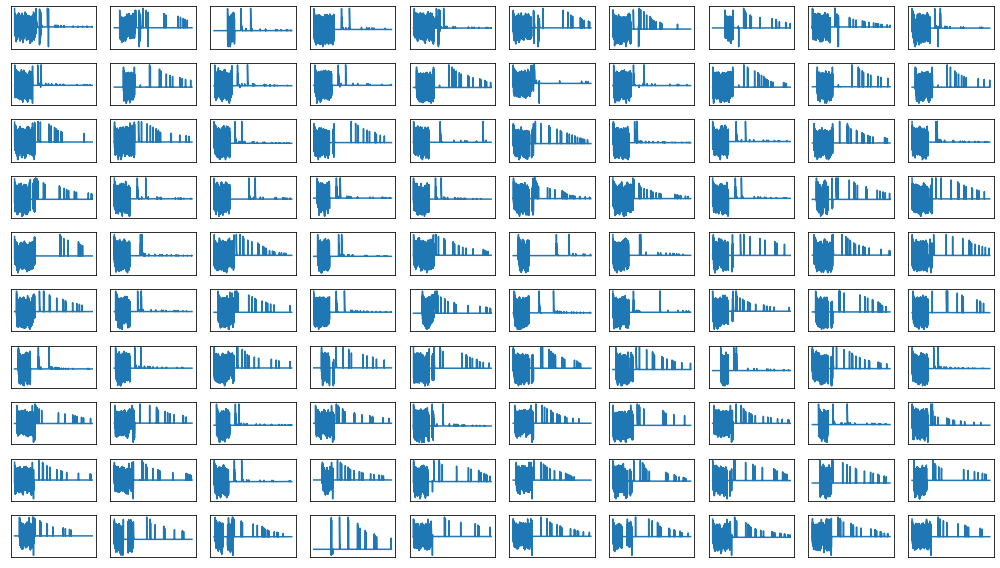

In [ ]:

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

grid = env.Devolver_Grid()

filas, columnas = size, size

fig = plt.figure(figsize=(14, 8))
for f in range(filas):
    for c in range(columnas):
        plt.subplot(filas, columnas, f*columnas + c + 1)
        plt.plot(grid[f+1][c+1].ERRORES)
        plt.xticks([])
        plt.yticks([]) 
#plt.xticks([])
#plt.yticks([])        
plt.tight_layout()
plt.show()



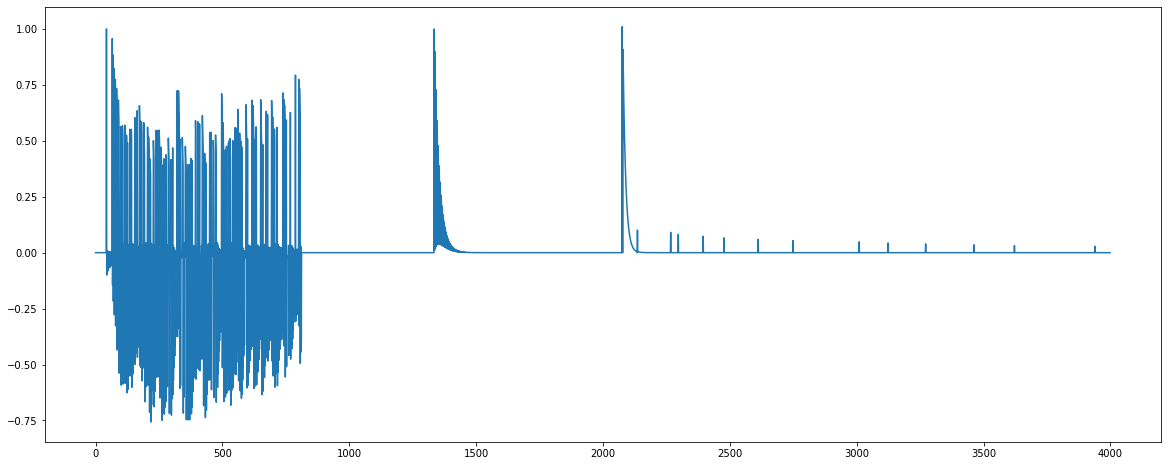

In [ ]:

# TENER EN CUENTA EL BORDE (Empezamos en el (1,1) del GRID)
# ------------------------
fig = plt.figure(figsize=(20, 8))
plt.plot(grid[6][6].ERRORES)


#**ESTUDIO de los MUTANTES**

In [ ]:

#grid = env.Devolver_Grid()
matriz_mutantes = np.zeros((size, size),dtype=int)

print('Identidad del GRID : id -> ', id(grid), '\n')

for i in range(1,size+1,1):        
  for j in range(1,size+1,1):
    #print(grid[i][j].MUTANTE)
    #matriz_mutantes[i][j] = grid[i][j].MUTANTE
    matriz_mutantes[i-1][j-1] = grid[i][j].Mutante()
    #matriz_mutantes[i][j] = 1

matriz_mutantes


Identidad del GRID : id ->  140494615940624 



array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

#**Representamos gráficamente la matriz Q de decisiones de uno de los agentes**

Procediendo a devolver referencia al GRID: id ->  139708376497872 



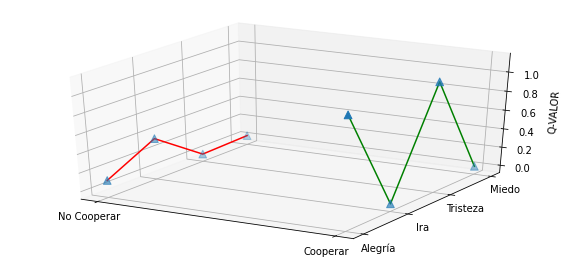

In [ ]:
# Matriz Q con los valores de cada ACCIÓN en cada ESTADO
# en uno de los agentes (Por ejemplo el (3,4))

# IMPORTAMOS LAS LIBRERÍAS
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# OBTENEMOS UNA COPIA DEL GRID
Grid2 = env.Devolver_Grid()

# EXTRACCIÓN DE LA MATRIZ Q
# -------------------------
matriz_Q = Grid2[6][6].Q() 
#matriz_Q = Grid2[3][6].Q() 
matriz_Q

# REPRESENTACIÓN GRÁFICA DE LA MATRIZ Q
# -------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
from matplotlib.pyplot import yticks
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211, projection ='3d')

rango_acciones  = np.arange(0,2)
rango_emociones = np.arange(0,4)

X, Y = np.meshgrid(rango_acciones, rango_emociones)
Z    = matriz_Q
ax.scatter3D(X, Y, Z, marker='^', s=60)

ax.plot3D([0,0,0,0], [0,1,2,3], Z[:,0], 'red')
ax.plot3D([1,1,1,1], [0,1,2,3], Z[:,1], 'green')
#ax.set_xlabel('ESTRATEGIA')
#ax.set_ylabel('EMOCIONES')
ax.set_zlabel('Q-VALOR')
locs, labels = xticks()
locs, labels = yticks()
xticks([0, 1], ['No Cooperar', 'Cooperar'])
yticks([0, 1, 2, 3], ['Alegría', 'Ira', 'Tristeza','Miedo'])

plt.show()


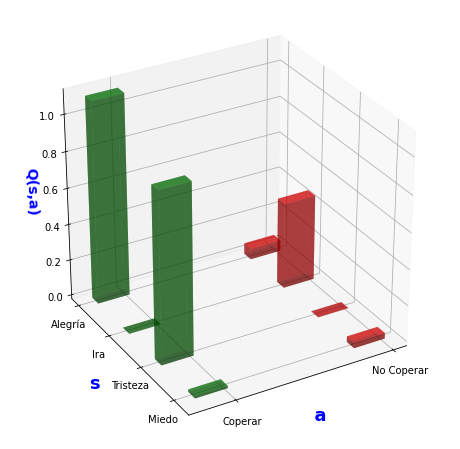

In [ ]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib.pyplot import xticks
from matplotlib.pyplot import yticks
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

matriz_Q = Grid2[5][5].Q() 
matriz_Q

#np.random.seed(1234)
#fig = plt.figure()
fig = plt.figure(figsize=(8, 8))
#fig.subplots_adjust(bottom=0.25, top=0.75)
ax1 = fig.add_subplot(111, projection='3d')
A = matriz_Q

colores = ['r','r','r','r','g','g','g','g']

x = np.array([[i] * 4 for i in range(2)]).ravel() # x coordinates of each bar
y = np.array([i for i in range(4)] * 2) # y coordinates of each bar
z = np.zeros(2*4) # z coordinates of each bar
dx = [0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2] #np.ones(2*4) # length along x-axis of each bar
dy = [0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2] #np.ones(2*4) # length along y-axis of each bar

dz = []
for columna in np.arange(2):
  for fila in np.arange(4):
    dz.append(matriz_Q[fila][columna])
dz = np.array(dz)

#dz = A.ravel() # length along z-axis of each bar (height)

ax1.bar3d(x, y, z, dx, dy, dz, color=colores, alpha=0.5)

#ax1.text2D(0.0, 0.1, "Valor de la función de valor estado-acción \n                 Q(s,a)")
#from matplotlib import rcParams
#rcParams['axes.labelpad'] = 6
#ax.zaxis.set_rotate_label(False) 
ax1.set_zlabel('Q(s,a)', fontsize=14, fontweight='bold', color='blue')
#locs, labels = xticks()
#locs, labels = yticks()
ax1.set_xlabel('  a', fontsize=18, fontweight='bold', color='blue')
ax1.set_ylabel('s   ', fontsize=18, fontweight='bold', color='blue', linespacing=22.2)
xticks([0, 1], ['No Coperar', 'Coperar'])
yticks([0, 1, 2, 3], ['Alegría', 'Ira', 'Tristeza','Miedo'])

#ax1.view_init(30,130)
ax1.view_init(30,60)

#**Creamos una animación con la evolución emocional y de la cooperación**

<function matplotlib.pyplot.close(fig=None)>

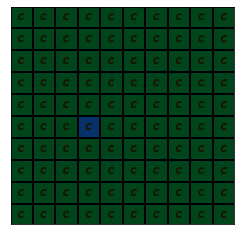

In [ ]:
# IMPORTAMOS LAS LIBRERÍAS
# ------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as FuncAnimation
from matplotlib import animation, rc
rc('animation',html='html5')
import numpy as np
import pandas as pd
%matplotlib inline


# ASOCIAMOS COLORES A EMOCIONES para posteriormente dibujarlas
# -----------------------------------------------------------------------------
cmaps = []
#cmaps.append(mpl.cm.Blues_r)      # Tristeza (azul)        => 0  ok
#cmaps.append(mpl.cm.Greens_r)     # Alegría      (verde)   => 1  ok   # <----------------- ERROR, emociones intercambiadas
#cmaps.append(mpl.cm.Reds_r)       # Ira          (rojo)    => 2  ok                        # *************** CORRECCIÓN
cmaps.append(mpl.cm.Greens_r)      # Alegría     (verde)    => 0  ok                        #  2 Agosto 2022
cmaps.append(mpl.cm.Reds_r)        # Ira          (rojo)    => 1  ok                        # ***************
cmaps.append(mpl.cm.Blues_r)       # Tristeza     (azul)    => 2  ok   # <----------------- ERROR, emociones intercambiadas
#cmaps.append(mpl.cm.Purples_r)     # Miedo     (púrpura)    => 3
#cmaps.append(mpl.cm.Greys_r)      # Miedo        (gris)     => 3       # EL GRIS SE CONFUNDE CON EL AZUL EN ALGUNOS GRADOS
                                                                       # pruebo con el NARANJA
cmaps.append(mpl.cm.Oranges_r)    #              (naranja) => 3
#cmaps.append(mpl.cm.Blues_r) 

# PARECE QUE SE VE MEJOR QUE EL GRIS LO PONGO DE MIEDO
                                  # Miedo        (gris)    => 3  ok
#cmaps.append(mpl.cm.Purples_r)    # Envidia      (púrpura) => 5
#cmaps.append(mpl.cm.Greys_r)      # Miedo        (gris)    => 3
#cmaps.append(mpl.cm.Oranges_r)    #              (naranja) => 4
#cmaps.append(mpl.cm.Purples_r)    # Envidia      (púrpura) => 5
# -----------------------------------------------------------------------------

# CONSTRUIMOS UNA MALLA DEL TAMAÑO DE LAS MATRICES para luego utilizarla en el dibujo
x = np.arange(0,size)
y = np.arange(0,size)
malla_dibujo = np.meshgrid(x,y)

# Fijamos el tamaño de la ventana en relación al tamaño del GRID
ratio = 0.4
fig, axes = plt.subplots(figsize=(ratio*size,ratio*size))
axes.set_facecolor("black")
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)


def update(i):
  acciones, emociones, intensidad = env.step()
  acciones_   = acciones[1:size+1,1:size+1]
  emociones_  = emociones[1:size+1,1:size+1]
  intensidad_ = intensidad[1:size+1,1:size+1]

  
  # PRUEBO ESTA TRANSFORMACIÓN PARA REVERTIR EL GAMMA  (21 de Julio de 2022)
  # Quiero que a más intensidad emocional, el color se más fuerto
  intensidad_ = 1 - intensidad_ 
  # -------------------------------------------------


  # ------------------------- 
  # TRANSFORMACIÓN: emociones  > CORREGIMOS EL GIRO ESPECULAR del meshgrid
  # -------------------------
  emociones_reverse_filas = emociones_[::-1]
  emociones___t = emociones_reverse_filas.flatten()
  # --------------------------------
  # TRANSFORMACIÓN: intensidad
  # -------------------------
  intensidad_reverse_filas = intensidad_[::-1]
  intensidad___t = intensidad_reverse_filas.flatten()
  # --------------------------------
  # TRANSFORMACIÓN: acciones
  # --------------------------------
  acciones_reverse_filas = acciones_[::-1]
  acciones___t = acciones_reverse_filas.flatten()
  # --------------------------------


  # v1 (antes de la corrección de la imagen especular)
  # --
  # Se degrada el color según baja el nivel de intensidad
  #colores     = [cmaps[color](intensidad) for color,intensidad in zip(emociones_.flatten(),intensidad_.flatten())]

  colores     = [cmaps[color](intensidad) for color,intensidad in zip(emociones___t,intensidad___t)]

  # v2 (30 Marzo 2022)
  # --
  # CAMBIO SIGUIENTE LINEA para dar vuelta a imagen especular que sale
  # ¡¡¡ !!!
  #color_amarillo =  [(0.990,0.990,0,1) if Coopera else (0,0,0,0) for Coopera in acciones.flatten()]
  #color_amarillo =  [(0.990,0.990,0,1) if Coopera else (0,0,0,0) for Coopera in acciones___t]


  #color_amarillo =  [(0.990,0.990,0,1) if Coopera else (0,0,0,0) for Coopera in acciones.flatten()]
  #color_amarillo   =  [(0.990,0.990,0,1) if Coopera else (0,0,0,0) for Coopera in acciones_.flatten()]     #  (22 de Julio de 2022)
  color_negro      =  [(0.090,0.090,0,1) if Coopera else (0,0,0,0) for Coopera in acciones_.flatten()]    # <-- Pongo color claro

  dibujo = axes.scatter(*malla_dibujo, marker='s', s=380)
  dibujo.set_facecolor(colores)
  # Sobreimpresionamos una 'C' cuando el agente COOPERA
  dibujo2 = axes.scatter(*malla_dibujo, marker='$C$')
  
  #dibujo2.set_facecolor(color_amarillo)                                                                    #  (22 de Julio de 2022)
  dibujo2.set_facecolor(color_negro)                                                                      # ----------------------
  
  return axes

# Creamos una animación con 40 ejecuciones (frames=40), y la separación entre los
# frames es de 1 segundo (interval=1000)
animacion = animation.FuncAnimation(fig, update, frames=40, interval=100)
plt.close

# -----------------------------------------------------------------------------------------
# inicialmente: interval = 1000
#               con 40 frames
# para valores más altos va lento. Pruebo a subir a 400 frames, y un valor mucho
# más pequeño para el intervalo (primero 100) que podría ser: 10.
#
# · PRUEBA 1 ----> frames (400) e interval (100) // éste último influye en la visualización
#                  tiempo de ejecución de este procedimiento: 14 minutos
#
# · PRUEBA 2 ----> frames (100) e interval (100)   *** pero con GRID (20*20)
#                  tiempo de ejecución                      :  5 minutos
# -----------------------------------------------------------------------------------------

In [ ]:

# Ver si se corresponde: a mayor intensidad, mayor valor desencadenante
#  + TRISTEZA alta ----> zonas de cooperación (donde está NO COOPERANDO)
#  + Tristeza baja ----> zonas de no cooperación
animacion


Procediendo a devolver referencia al GRID: id ->  139708376497872 



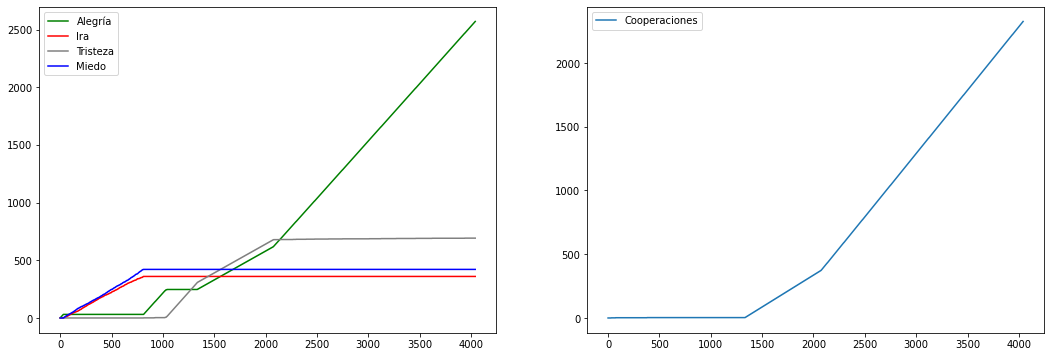

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# OBTENEMOS UNA COPIA DEL GRID
Grid2 = env.Devolver_Grid()

# EXTRACCIÓN DE LAS SERIES EMOCIONALES
# ------------------------------------
serie1  = Grid2[6][6].SERIE_ALEGRIA 
serie2  = Grid2[6][6].SERIE_IRA
serie3  = Grid2[6][6].SERIE_TRISTEZA
serie4  = Grid2[6][6].SERIE_MIEDO
serie_c = Grid2[6][6].SERIE_COOPERACIONES[:-1]

fig = plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(serie1, label='Alegría', color='green')
plt.plot(serie2, label='Ira', color='red')
plt.plot(serie3, label='Tristeza', color='gray')
plt.plot(serie4, label='Miedo', color='blue')
plt.legend(loc="upper left")

plt.subplot(122)
plt.plot(serie_c, label='Cooperaciones')
plt.legend(loc='upper left')

In [ ]:
# TRANSFORMAMOS LOS CONTEOS DE TRANSICIONES ENTRE EMOCIONES      ----> vemos un AGENTE MUTANTE: En esta realización (2,3)
# ---------------------------------------------------------
# Lo colocamos en un rango no muy alto (dividiendo por el total
# de transiciones para luego usar estos valores como grosor
# de las aristas)

Matriz_adj = Grid2[2][3].MATRIZ_ADYACENCIA_EMOCIONES
Matriz_adj = Matriz_adj*(18/CICLOS)
Matriz_adj

array([[1.09395e+01, 4.50000e-03, 1.23300e+00, 0.00000e+00],
       [0.00000e+00, 9.76500e-01, 0.00000e+00, 1.06650e+00],
       [1.23750e+00, 0.00000e+00, 7.69500e-01, 0.00000e+00],
       [4.50000e-03, 1.06200e+00, 0.00000e+00, 8.95500e-01]])

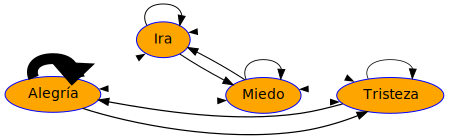

In [ ]:
# IMPORTAMOS LAS LIBRERÍAS
# ------------------------
import networkx as nx
import graphviz as gv

# Create Digraph object
dot = gv.Digraph('wide')

# Add nodes
#dot.attr('node', shape='doublecircle') # O también: shape='circle'
dot.node('0', 'Alegría', color='blue', 
         fillcolor="orange", 
         style='filled', 
         fontname="Verdana")          # 0 es Alegría
dot.node('1', 'Ira', color='blue', fillcolor="orange", style='filled', fontname="Verdana")              # 1 es Ira
dot.node('2', 'Tristeza', color='blue', fillcolor="orange", style='filled', fontname="Verdana")         # 2 es Tristeza
dot.node('3', 'Miedo', color='blue', fillcolor="orange", style='filled', fontname="Verdana")            # 3 es Miedo

for emocion_inicial in range(4):
  for emocion_final in range(4):
    dot.attr('edge', penwidth=str(Matriz_adj[emocion_inicial][emocion_final]))
    dot.edge(str(emocion_inicial), str(emocion_final))

# ORIENTACIÓN DE IZQUIERDA A DERECHA
dot.graph_attr['rankdir'] = 'LR'  

# Visualize the graph
dot

In [ ]:
# TRANSFORMAMOS LOS CONTEOS DE TRANSICIONES ENTRE EMOCIONES      -->   UN AGENTE EMOCIONAL (6,6)
# ---------------------------------------------------------
# Lo colocamos en un rango no muy alto (dividiendo por el total
# de transiciones para luego usar estos valores como grosor
# de las aristas)

Matriz_adj = Grid2[6][6].MATRIZ_ADYACENCIA_EMOCIONES
Matriz_adj = Matriz_adj*(18/CICLOS)
Matriz_adj

array([[9.8055e+00, 4.5000e-03, 1.7505e+00, 0.0000e+00],
       [0.0000e+00, 8.0550e-01, 4.5000e-03, 8.1000e-01],
       [1.7550e+00, 0.0000e+00, 1.3590e+00, 0.0000e+00],
       [0.0000e+00, 8.1000e-01, 0.0000e+00, 1.0845e+00]])

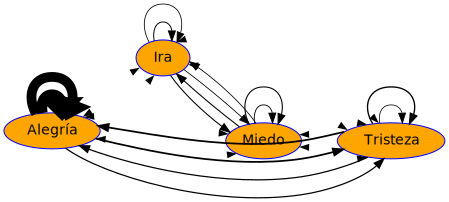

In [ ]:

# SE ACUMULA, ASÍ QUE SI EJECUTO VARIAS VECES LAS CELDAS
# APARECEN MUCHAS MÁS LINEAS INTERCONECTANDO LOS NODOS
# ======================================================

for emocion_inicial in range(4):
  for emocion_final in range(4):
    dot.attr('edge', penwidth=str(Matriz_adj[emocion_inicial][emocion_final]))
    dot.edge(str(emocion_inicial), str(emocion_final))

# ORIENTACIÓN DE IZQUIERDA A DERECHA
dot.graph_attr['rankdir'] = 'LR'  

# Visualize the graph
dot

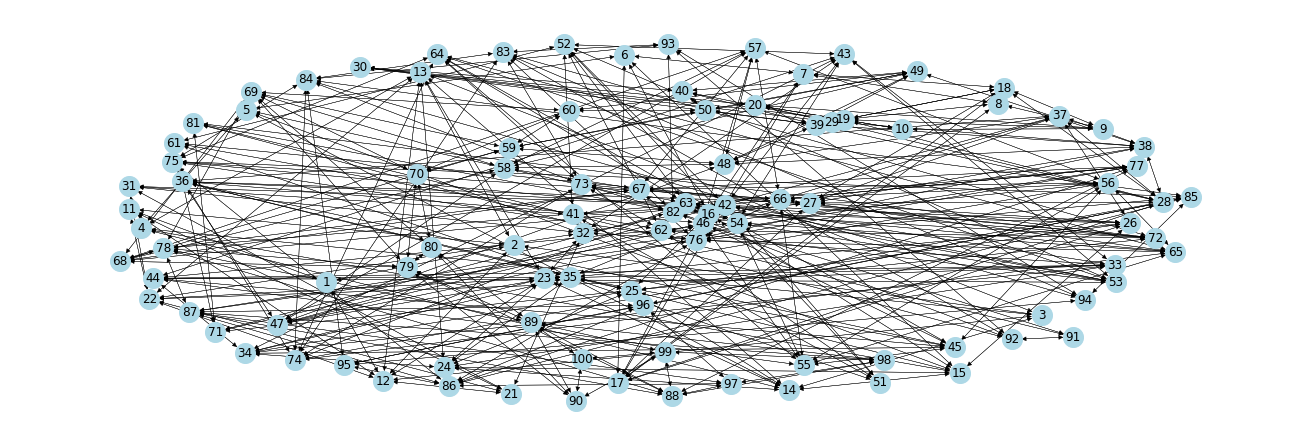

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# PREPARAMOS EL TAMAÑO DEL DIBUJO DE LA RED
# -----------------------------------------
plt.figure(figsize=(18,6))
#ax = fig.add_subplot(111)

# Instanciamos el GRAFO
# ---------------------
Grafo = nx.DiGraph()


# ======================
# PREPARAMOS EL GRÁFICO
# ======================

# LISTADO DE NODOS
# ----------------
contador_nodos = 1
for i in range(1,size+1,1):        
  for j in range(1,size+1,1):
    #self.Grafo.add_node(Grid[i][j].Numero_nodo)
      Grafo.add_node(contador_nodos)
      contador_nodos += 1


# LISTADO DE COLORES para los NODOS basado en el tipo de mutante
# --------------------------------------------------------------
#global 
LISTA_MUTANTES

color_legend = {'Agente Emocional': 'orange', 'Agente Traidor': 'red',
                'Agente Ingenuo': 'lightgreen'  , 'Agente TitForTat': 'lightgray'}
d = {0: 'orange', 1: 'red', 2: 'lightgreen', 3: 'lightgray'}
color_map = [d.get(x) for x in LISTA_MUTANTES]
# --------------------------------------------------------------


# PREPARAMOS LAS ARISTAS CON PESO PROPORCIONAL AL NÚMERO DE COOPERACIONES
# (entre los nodos que unen)
# -----------------------------------------------------------------------
for i in range(size):        
  for j in range(size):
    lista = [(i*size + j + 1, nodo_destino) 
                          for nodo_destino in LISTA_NODOS_VECINOS[i*size + j]]
    lista_ponderada = [(nodo_i, nodo_j, MATRIZ_ADYACENCIA_Red_Social[nodo_i][nodo_j]) 
                        for nodo_i, nodo_j in lista]  
    Grafo.add_weighted_edges_from(lista_ponderada)                   

# ===================================================================================                   

#nx.draw_networkx(Grafo, ax = ax, node_color=color_map)
#nx.draw_networkx(Grafo, node_color=color_map[:size*size])

nx.draw(Grafo, pos = nx.spring_layout(Grafo, k=0.8), with_labels = True, width=0.4, 
        node_color='lightblue', node_size=400)

Procediendo a devolver referencia al GRID: id ->  139813527639696 



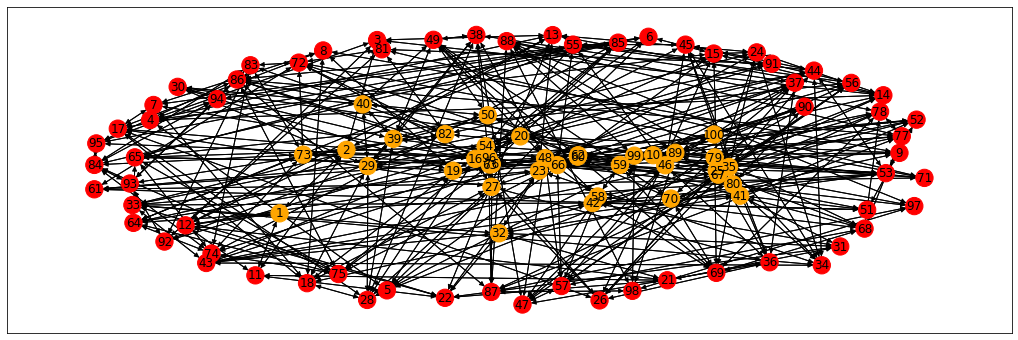

In [ ]:

# OBTENEMOS UNA COPIA DEL GRID
# ----------------------------
Grid = env.Devolver_Grid()

# PARÁMETROS (tamaño y matriz de adyacencia)
# ----------
Matriz_adj = env.MATRIZ_Adj
Matriz_adj = Matriz_adj*(2/CICLOS)

plt.figure(figsize=(18,6))

len(color_map)

# NO SÉ PORQUE SALE UN ARRAY MUCHO MAYOR QUE LOS MUTANTES QUE AÑADO
# (Corto hasta el máximo para que coincida)
# -----------------------------------------------------------------
nx.draw_networkx(Grafo, node_color=color_map[:size*size])

In [ ]:
len(LISTA_MUTANTES)

72

#**<font color='green'>Preparando la generación de las secuencias de observaciones para alimentar la red**</font>.

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/MEZCLAS_POBLACIONALES_3.png?raw=true' width="1000"/>
<figcaption></figcaption></center>
</figure>




#**PROCESO**:
Previamente realizamos un estudio sobre las proporciones entre poblaciones. El caso que parece más interesante es el del MUTANTE TRAIDOR. Estudiamos su introducción en la población en distintas proporciones.

· Variamos el valor de 'p' y analizamos cómo varía el número de COOPERACIONES

· Podemos estudiar simultáneamente el valor de $\beta$, el parámetro de desescalada que introdujimos

Las SIMULACIONES llevadas en conjunto es un proceso largo que dura aproximadamente 1 hora.

**RESULTADOS:**

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/Estudio_parametro_de_desescalada_1a.png?raw=true' width="600"/>
<figcaption></figcaption></center>
</figure>

